In [11]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)
from glob import glob

In [12]:
!ls /net/kage/d5/datasets

20CRv2	     CRU3.25	 GHCN-D   ICOADS      NARR	     OAFlux
20CRv2-2008  ERA-1deg	 GPCC	  index.tex   NARR07	     ORAs4
20CRv2c      ERA20C	 GPCP	  index.tex~  NCEP-NCAR      PO-DACC
basins	     ERA40	 HadEX2   jma	      noaa.oisst.v2  Sea-Ice
COBE-SST2    ERAInterim  HadISST  LENS	      NOAA-SST
CRU3.10      ERSST	 HadSLP   MERRA       NOCS_v2


In [13]:
path = '/net/kage/d5/datasets/ERAInterim/monthly/'
#dirs = glob(path+'/*'); dirs

In [14]:
ddict = {'Surface':path+'Surface/*.nc','VertInt':path+'VertInt/*.nc',
         'Accum':path+'Accum/*.nc','PressureLevels':path+'PressureLevels/*.nc'}
for key, value in ddict.items():
    print(key,value)

Surface /net/kage/d5/datasets/ERAInterim/monthly/Surface/*.nc
VertInt /net/kage/d5/datasets/ERAInterim/monthly/VertInt/*.nc
Accum /net/kage/d5/datasets/ERAInterim/monthly/Accum/*.nc
PressureLevels /net/kage/d5/datasets/ERAInterim/monthly/PressureLevels/*.nc


In [15]:
dtype = 'VertInt'
ds_tmp = xr.open_mfdataset(glob(ddict[dtype]),decode_times=False)
names = list(ds_tmp.data_vars.variables)

In [16]:
for var in sorted(names):
    print(var+':\t',ds_tmp[var].long_name)

p53:	 Vertical integral of mass of atmosphere
p54:	 Vertical integral of temperature
p55:	 Vertical integral of water vapour
p56:	 Vertical integral of cloud liquid water
p57:	 Vertical integral of cloud frozen water
p58:	 Vertical integral of ozone
p59:	 Vertical integral of kinetic energy
p60:	 Vertical integral of thermal energy
p61:	 Vertical integral of potential+internal energy
p62:	 Vertical integral of potential+internal+latent energy
p63:	 Vertical integral of total energy
p64:	 Vertical integral of energy conversion
p65:	 Vertical integral of eastward mass flux
p66:	 Vertical integral of northward mass flux
p67:	 Vertical integral of eastward kinetic energy flux
p68:	 Vertical integral of northward kinetic energy flux
p69:	 Vertical integral of eastward heat flux
p70:	 Vertical integral of northward heat flux
p71:	 Vertical integral of eastward water vapour flux
p72:	 Vertical integral of northward water vapour flux
p73:	 Vertical integral of eastward geopotential flux
p74:	 

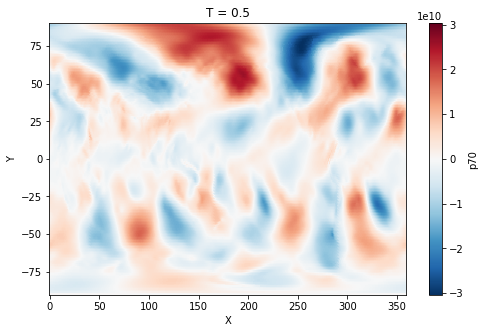

In [21]:
ds_tmp.p70[0,:,:].plot()

In [22]:
ds_tmp['T'][0]

<xarray.DataArray 'T' ()>
array(0.5, dtype=float32)
Coordinates:
    T        float32 0.5
Attributes:
    calendar:    360
    pointwidth:  1.0
    gridtype:    0
    units:       months since 1979-01-01

In [23]:
def to_pandas(Tgrid):
    """
    Parse the time grid of a Dataset and replace by a pandas time grid.
    """
    # first get the reference year from units
    words = Tgrid.units.split()
    ref_year = int(words[2][0:4])
    # get the first time grid value
    first_time = Tgrid.values[0] - 0.5
    datetime = enso2date(first_time,ref_year)
    if 'months since' in Tgrid.units:
        return pd.date_range(datetime, periods=Tgrid.shape[0], freq='MS').shift(15, freq='D')
    elif 'days since' in Tgrid.units:
        return pd.date_range(datetime, periods=Tgrid.shape[0], freq='D')
    else:
        print('Unrecognized time grid')
        return

In [24]:
def enso2date(T0,ryear=1960,leap=True):
    norm = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    iy = ryear + int(T0/12)
    if T0 < 0:
        iy = iy - 1
    res = T0 - (iy - ryear)*12
    im = int(res) + 1
    if im == 13:
        im = 1
        iy = iy + 1
    if leap & (im == 2) &  (iy % 4 == 0 ):   
        id = 1 + int(29 * (res - int(res)))
    else:
        id = 1 + int(norm[im-1] * (res - int(res)))
    return str(im)+'/'+str(id)+'/'+str(iy)

enso2date(1.999),enso2date(13.999)

('2/29/1960', '2/28/1961')

In [25]:
Tgrid = ds_tmp['T']
to_pandas(Tgrid)

DatetimeIndex(['1979-01-16', '1979-02-16', '1979-03-16', '1979-04-16',
               '1979-05-16', '1979-06-16', '1979-07-16', '1979-08-16',
               '1979-09-16', '1979-10-16',
               ...
               '2016-03-16', '2016-04-16', '2016-05-16', '2016-06-16',
               '2016-07-16', '2016-08-16', '2016-09-16', '2016-10-16',
               '2016-11-16', '2016-12-16'],
              dtype='datetime64[ns]', length=456, freq=None)

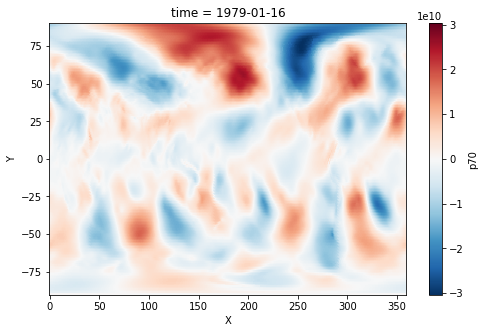

In [28]:
ds = ds_tmp.p70.rename({'T':'time'})
ds['time'] = to_pandas(Tgrid)
ds[0,:,:].plot()

In [30]:
ds.to_netcdf('t2m.nc',encoding={'time':{'dtype':'float32'}})

In [31]:
dtype = 'PressureLevels'
ds_tmp = xr.open_mfdataset(glob(ddict[dtype]),decode_times=False)

Tgrid = ds_tmp['T']
ds_tmp['T'] = to_pandas(Tgrid) 
ds_tmp['T']

<xarray.DataArray 'T' (T: 456)>
array(['1979-01-16T00:00:00.000000000', '1979-02-16T00:00:00.000000000',
       '1979-03-16T00:00:00.000000000', ..., '2016-10-16T00:00:00.000000000',
       '2016-11-16T00:00:00.000000000', '2016-12-16T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * T        (T) datetime64[ns] 1979-01-16 1979-02-16 1979-03-16 1979-04-16 ...

In [32]:
ds_PL = ds_tmp.rename({'T':'time'})

In [33]:
names = list(ds_PL.data_vars.variables); names

['q', 'u', 'v', 'r', 'w', 't']

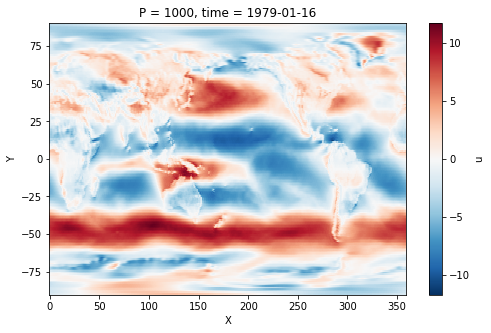

In [34]:
ds_PL.u[0,0].plot()

In [35]:
#ds_PL.u.to_netcdf('u.nc',encoding={'time':{'dtype':'float32'}})

In [36]:
dtype = 'Accum'
ds_tmp = xr.open_mfdataset(glob(ddict[dtype]),decode_times=False)
names = list(ds_tmp.data_vars.variables)
for var in sorted(names):
    print(var+':\t',ds_tmp[var].long_name)

bld:	 Boundary layer dissipation
cp:	 Convective precipitation
csf:	 Convective snowfall
es:	 Snow evaporation
evap:	 Evaporation
ewss:	 Eastward turbulent surface stress
gwd:	 Gravity wave dissipation
lgws:	 Eastward gravity wave surface stress
lsf:	 Large-scale snowfall
lsp:	 Large-scale precipitation
lspf:	 Large-scale precipitation fraction
magss:	 Magnitude of turbulent surface stress
mgws:	 Northward gravity wave surface stress
nsss:	 Northward turbulent surface stress
par:	 Photosynthetically active radiation at the surface
parcs:	 Clear sky surface photosynthetically active radiation
ro:	 Runoff
sf:	 Snowfall
slhf:	 Surface latent heat flux
smlt:	 Snowmelt
sshf:	 Surface sensible heat flux
ssr:	 Surface net solar radiation
ssrc:	 Surface net solar radiation, clear sky
ssrd:	 Surface solar radiation downwards
str:	 Surface net thermal radiation
strc:	 Surface net thermal radiation, clear sky
strd:	 Surface thermal radiation downwards
sund:	 Sunshine duration
tisr:	 TOA incident 

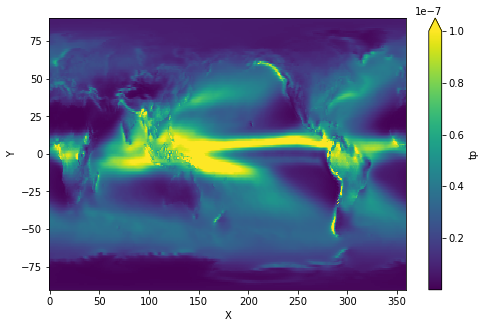

In [37]:
Tgrid = ds_tmp['T']
ds_Accum = ds_tmp.rename({'T':'time'})
ds_Accum['time'] = to_pandas(Tgrid)
ds_Accum.tp.mean('time').plot(vmax = 1e-7)

In [38]:
ds_Accum.tp.to_netcdf('tp.nc',encoding={'time':{'dtype':'float32'}})